---
title: Fit linear mode to linear data
date: 2025-04-03
author: Haky Im
eval: false
---

## fit a linear model to linear data


- We generate a data Y linearly dependent on features X: $Y = X\beta + \epsilon$

- We fit a linear model 

    - with gradient descent

    - with pytorch framework

    - with traditional linear regression estimate
        $\hat\beta = (X^TX)^{-1}X^TY$


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.linear_model import LinearRegression
import pandas as pd
from plotnine import *

# Generate synthetic data
np.random.seed(42)
X = np.random.randn(100, 1) * 2  # 100 samples, 1 feature
y = 3 * X + 2 + np.random.randn(100, 1) * 0.5  # y = 3x + 2 + noise

# Convert to PyTorch tensors
X_tensor = torch.FloatTensor(X)
y_tensor = torch.FloatTensor(y)

# define a linear model
class LinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(1, 1)  # 1 input feature, 1 output
    def forward(self, x):
        return self.linear(x)

# instantiate the model
model = LinearModel()

# define a loss function
loss_fn = nn.MSELoss()

# define an optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Train: iterate over the data and update the model
num_epochs = 100
for epoch in range(num_epochs):
    # Forward pass: compute model predictions and loss
    y_pred = model(X_tensor)
    loss = loss_fn(y_pred, y_tensor)
    
    # Backward pass and parameter update
    optimizer.zero_grad()  # Clear previous gradients
    loss.backward()        # Compute gradients via backpropagation
    optimizer.step()       # Update model parameters
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# check performance

# compute PyTorch model predictions
model.eval()
with torch.no_grad():
    y_pred_pytorch = model(X_tensor).numpy()

# compute scikit-learn predictions
lr = LinearRegression()
lr.fit(X, y)
y_pred_sklearn = lr.predict(X)

# compare coefficients
print("\nPyTorch model coefficients:")
print(f"Slope: {model.linear.weight.item():.4f}")
print(f"Intercept: {model.linear.bias.item():.4f}")

print("\nScikit-learn coefficients:")
print(f"Slope: {lr.coef_[0][0]:.4f}")
print(f"Intercept: {lr.intercept_[0]:.4f}")

# compare MSE
mse_pytorch = np.mean((y - y_pred_pytorch) ** 2)
mse_sklearn = np.mean((y - y_pred_sklearn) ** 2)
print(f"\nPyTorch MSE: {mse_pytorch:.4f}")
print(f"Scikit-learn MSE: {mse_sklearn:.4f}")



## plot predictions vs true

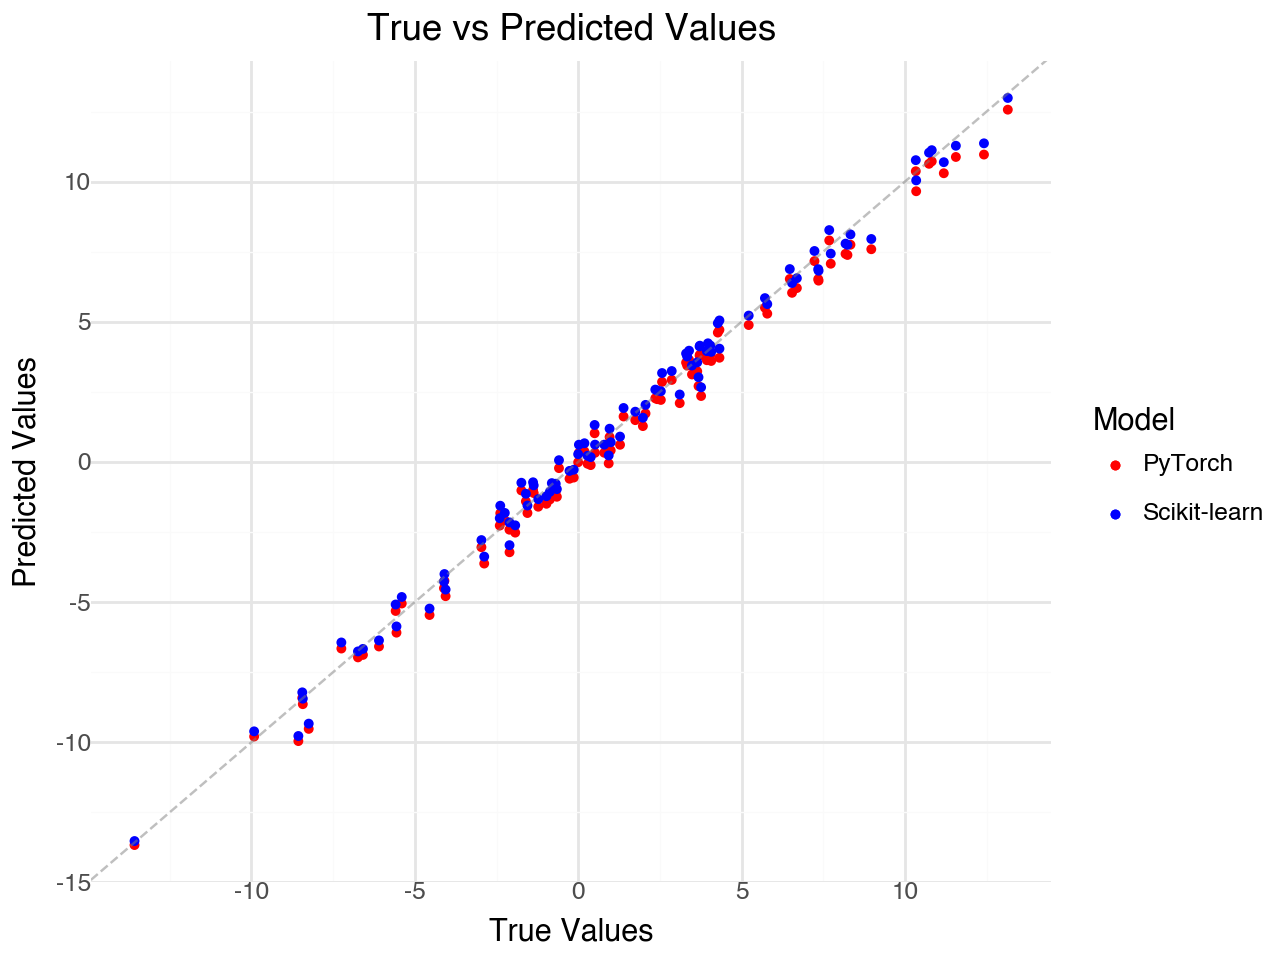

In [3]:
# Create a plot comparing predictions
# Create a DataFrame for plotting
plot_df = pd.DataFrame({
    'y_true': y.flatten(),
    'y_pred_pytorch': y_pred_pytorch.flatten(),
    'y_pred_sklearn': y_pred_sklearn.flatten()
})

# Create the plot
p = (ggplot(plot_df)
    + geom_point(aes(x='y_true', y='y_pred_pytorch', color='"PyTorch"'), size=1)
    + geom_point(aes(x='y_true', y='y_pred_sklearn', color='"Scikit-learn"'), size=1)
    + geom_abline(intercept=0, slope=1, color='gray', linetype='dashed', alpha=0.5)  # Identity line
    + scale_color_manual(values=['red', 'blue'])
    + labs(x='True Values', y='Predicted Values', 
           title='True vs Predicted Values',
           color='Model')
    + theme_minimal()
)

p

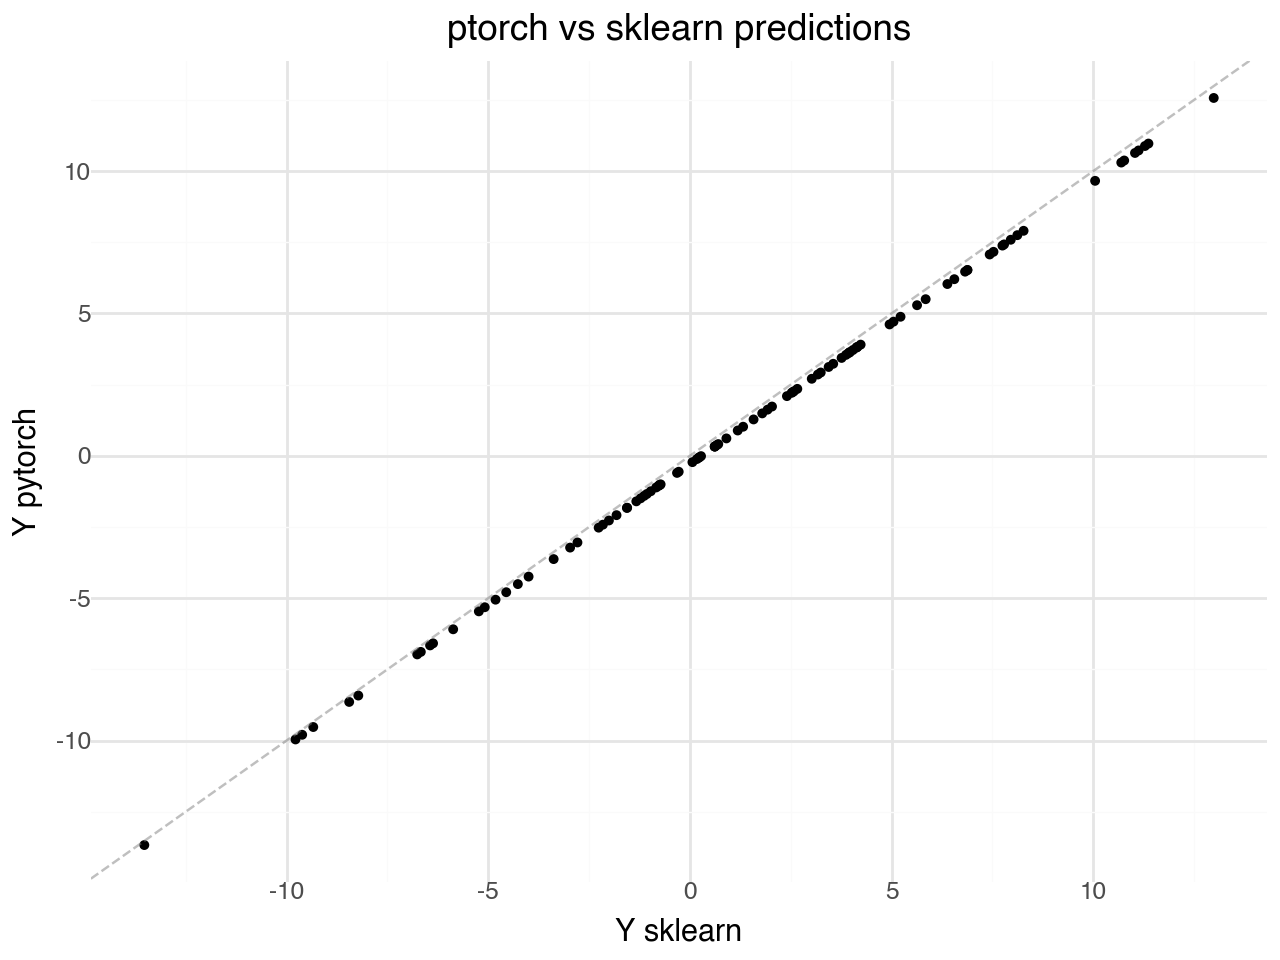

In [4]:
(ggplot(plot_df)
    + geom_point(aes(x='y_pred_sklearn', y='y_pred_pytorch'), size=1)
    + geom_abline(intercept=0, slope=1, color='gray', linetype='dashed', alpha=0.5)  # Identity line
    + labs(x='Y sklearn', y='Y pytorch', 
           title='ptorch vs sklearn predictions',
           color='Model')
    + theme_minimal()
)

## Fit linear model using the GPU

In [ ]:
# Train on GPU (checking for both MPS and CUDA)
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.linear_model import LinearRegression
import pandas as pd
from plotnine import *

# Check for available GPU devices
if torch.backends.mps.is_available():
    device = torch.device('mps')  # Apple Silicon
    print("Using MPS (Apple Silicon GPU)")
elif torch.cuda.is_available():
    device = torch.device('cuda')  # NVIDIA GPU
    print("Using CUDA (NVIDIA GPU)")
else:
    device = torch.device('cpu')  # Fallback to CPU
    print("Using CPU (no GPU available)")

# Generate synthetic data (stays on CPU)
np.random.seed(42)
X = np.random.randn(100, 1) * 2
y = 3 * X + 2 + np.random.randn(100, 1) * 0.5

# Convert to PyTorch tensors and move to GPU
X_tensor = torch.FloatTensor(X).to(device)
y_tensor = torch.FloatTensor(y).to(device)

# Define and move model to GPU
class LinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(1, 1)

    def forward(self, x):
        return self.linear(x)

model = LinearModel().to(device)
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training loop (same as before, but data is on GPU)
num_epochs = 100
for epoch in range(num_epochs):
    # Forward pass
    y_pred = model(X_tensor)
    loss = loss_fn(y_pred, y_tensor)
    
    # Backward pass and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Get predictions back to CPU for comparison
model.eval()
with torch.no_grad():
    y_pred_pytorch = model(X_tensor).cpu().numpy()  # Move back to CPU before converting to numpy

# Compare with scikit-learn (on CPU)
lr = LinearRegression()
lr.fit(X, y)
y_pred_sklearn = lr.predict(X)

# Compare coefficients
print("\nPyTorch model coefficients:")
print(f"Slope: {model.linear.weight.item():.4f}")
print(f"Intercept: {model.linear.bias.item():.4f}")

print("\nScikit-learn coefficients:")
print(f"Slope: {lr.coef_[0][0]:.4f}")
print(f"Intercept: {lr.intercept_[0]:.4f}")

# Compare MSE
mse_pytorch = np.mean((y - y_pred_pytorch) ** 2)
mse_sklearn = np.mean((y - y_pred_sklearn) ** 2)
print(f"\nPyTorch MSE: {mse_pytorch:.4f}")
print(f"Scikit-learn MSE: {mse_sklearn:.4f}")

# Create a plot comparing predictions
plot_df = pd.DataFrame({
    'y_true': y.flatten(),
    'y_pred_pytorch': y_pred_pytorch.flatten(),
    'y_pred_sklearn': y_pred_sklearn.flatten()
})

# Create the plot
p = (ggplot(plot_df)
    + geom_point(aes(x='y_true', y='y_pred_pytorch', color='"PyTorch"'), size=1)
    + geom_point(aes(x='y_true', y='y_pred_sklearn', color='"Scikit-learn"'), size=1)
    + geom_abline(intercept=0, slope=1, color='gray', linetype='dashed', alpha=0.5)  # Identity line
    + scale_color_manual(values=['red', 'blue'])
    + labs(x='True Values', y='Predicted Values', 
           title=f'True vs Predicted Values (Training on {device})',
           color='Model')
    + theme_minimal()
)

p